# Предобработка данных

Задание:

Цель: Помочь категорийному менеджеру, закупающему арматуру, сэкономить.
В репозитории файлах train и test есть понедельная история рыночных цен на арматуру в промежутке 2015-2023 гг. Также в репозитории представлены дополнительные данные, которые можно использовать для прогнозирования цены. Любые другие внешние данные использовать запрещено.


Необходимо разработать модель, которая по истории цен и дополнительных данных за период [1,T] делает рекомендацию по объему тендера на арматуру для недели T. 
Рекомендация на N недель фиксирует цену на N недель, следующий тендер будет проведен на неделе T+N. Считаем, что тендеры проводятся по понедельникам, для прогноза на следующие N недель оперировать можно историческими данными до понедельника включительно.

На основе полученной модели, необходимо разработать приложение для пользователя (категорийного менеджера) с интуитивно понятным интерфейсом


In [ ]:
# импорт основных библиотек для работы с датасетом и визуализациями
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from functools import reduce

In [302]:
# загрузка датасета с целевой переменной и просмотр базовой информации
train = pd.read_excel('data/train.xlsx', parse_dates=['dt'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [303]:
test = pd.read_excel('data/test.xlsx', parse_dates=['dt'])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 576.0 bytes


In [304]:
price_df = pd.concat([train, test]).sort_values('dt').reset_index(drop=True)

In [305]:
price_df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
423,2023-02-13,44500
424,2023-02-20,46000
425,2023-02-27,49200
426,2023-03-06,53700


In [306]:
# загрузка доп. данных
df_1 = pd.read_excel('data/Грузоперевозки.xlsx', parse_dates=['dt'])
df_2 = pd.read_excel('data/Данные рынка стройматериалов.xlsx', parse_dates=['dt'])
df_3 = pd.read_excel('data/Индекс LME.xlsx', parse_dates=['дата'])
df_3.rename(columns={'дата': 'dt'}, inplace=True)
df_4 = pd.read_excel('data/Показатели рынка металла.xlsx', parse_dates=['dt'])
df_5 = pd.read_excel('data/Топливо.xlsx', parse_dates=['dt'])
df_6 = pd.read_excel('data/Цены на сырье.xlsx', parse_dates=['dt'])

In [307]:
# создание списка со всеми дополнительными датасетами для легкости работы с ними
datasets = [price_df, df_1, df_2, df_3, df_4, df_5, df_6]

In [308]:
# удаление пустых значений в колонке с датой, если таковые имеются
for df in datasets:
  df = df.dropna(subset=['dt'])
  print(df.dt.isna().value_counts())
  print('-------------')

dt
False    428
Name: count, dtype: int64
-------------
dt
False    302
Name: count, dtype: int64
-------------
dt
False    25
Name: count, dtype: int64
-------------
dt
False    516
Name: count, dtype: int64
-------------
dt
False    85
Name: count, dtype: int64
-------------
dt
False    76
Name: count, dtype: int64
-------------
dt
False    423
Name: count, dtype: int64
-------------


In [ ]:
for i, dataframe in enumerate(datasets):
    dataframe['dt'] = pd.to_datetime(dataframe['dt'], format='%Y-%m-%d')
    datasets[i] = dataframe.set_index('dt').resample('W-MON').mean().reset_index()


df_extended = reduce(lambda left, right: pd.merge(left, right, on='dt', how='left'), datasets)
df_extended

,dt,Цена на арматуру,Индекс стоимости грузоперевозок,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-01-05,32900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-12,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-19,32000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-26,30700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-02-02,30300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,2023-02-13,44500.0,1322.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22765.0,457.5,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
424,2023-02-20,46000.0,1330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23414.0,465.0,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
425,2023-02-27,49200.0,1343.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24014.0,455.0,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0
426,2023-03-06,53700.0,1372.0,127.55719,56.7124,1395.32091,323.144673,4.104,194.063078,62.10118,...,24005.0,467.5,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0


<Axes: >

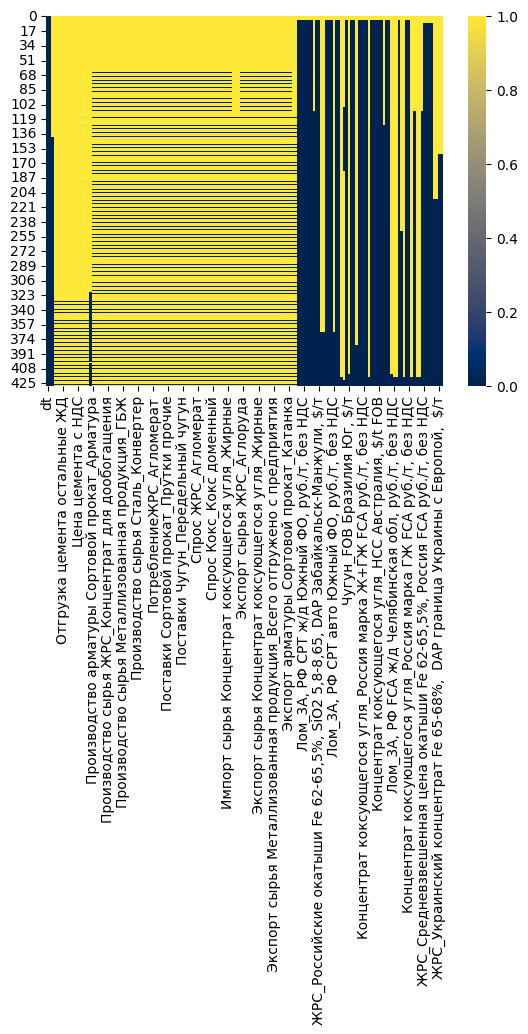

In [310]:
sns.heatmap(df_extended.isnull(), cmap='cividis')

In [311]:
# дроп колонок по трешхолду
def drop_columns_with_nan(df, threshold_percent):
  nan_percentages = df.isnull().mean() * 100

  columns_to_drop = nan_percentages[nan_percentages > threshold_percent].index.tolist()
  print(f"Было найдено {len(columns_to_drop)} колонок с содержанием NaN значений больше чем {threshold_percent}%")
  return columns_to_drop

threshold = 50
columns_to_drop = drop_columns_with_nan(df_extended, threshold)
df_extended = df_extended.drop(columns=columns_to_drop)

df_extended = df_extended.interpolate(method='linear').fillna(method='bfill')  # заполнение назад
df_extended = df_extended.interpolate(method='linear').fillna(method='ffill')  # заполнение вперёд

print(df_extended.shape)
print(f"{df_extended['dt'].min()} - {df_extended['dt'].max()}")

Было найдено 113 колонок с содержанием NaN значений больше чем 50%
(428, 45)
2015-01-05 00:00:00 - 2023-03-13 00:00:00


C:\Users\Илья\AppData\Local\Temp\ipykernel_20648\3342111742.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_extended = df_extended.interpolate(method='linear').fillna(method='bfill')  # заполнение назад
C:\Users\Илья\AppData\Local\Temp\ipykernel_20648\3342111742.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_extended = df_extended.interpolate(method='linear').fillna(method='ffill')  # заполнение вперёд


<Axes: >

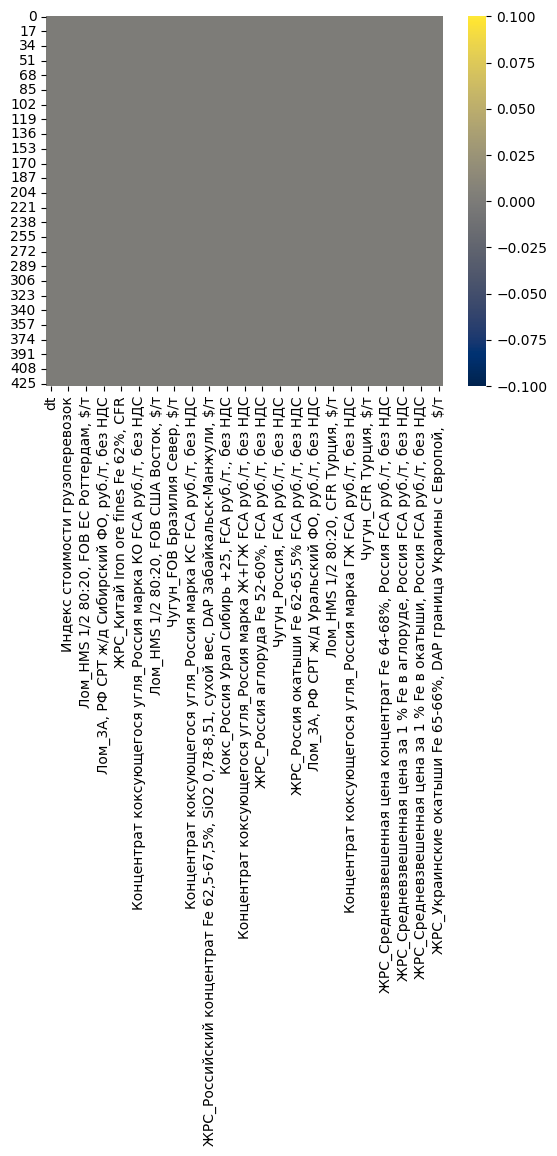

In [312]:
sns.heatmap(df_extended.isnull(), cmap='cividis')

In [313]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 45 columns):
 #   Column                                                                                            Non-Null Count  Dtype         
---  ------                                                                                            --------------  -----         
 0   dt                                                                                                428 non-null    datetime64[ns]
 1   Цена на арматуру                                                                                  428 non-null    float64       
 2   Индекс стоимости грузоперевозок                                                                   428 non-null    float64       
 3   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  428 non-null    float64       
 4   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                              

После всех преобразований в данных не осталось пропусков и все типы данных расставлены верно. К сожалению мы теряем некоторые дополнительные данные, например те, которые брались за месяц - можно было бы попробовать поставить эту месячную дату на весь месяц и получить больше данных, но этого я пока делать не буду, чтобы не потерять много времени.

Перед сохранением финальной версии датасета для модели возьму дату за индекс и добавлю дополнительные колонки на её основе.

In [314]:
df_extended.set_index('dt', inplace=True)

In [315]:
df_extended['year'] = df_extended.index.year
df_extended['month'] = df_extended.index.month
df_extended['day'] = df_extended.index.day
df_extended['quarter'] = df_extended.index.quarter 

In [316]:
df_extended.to_csv("to-modal.csv", index=True)

# Анализ

## Общие графики
Рассмотрим общие графики чтобы увидеть изменяемость данных

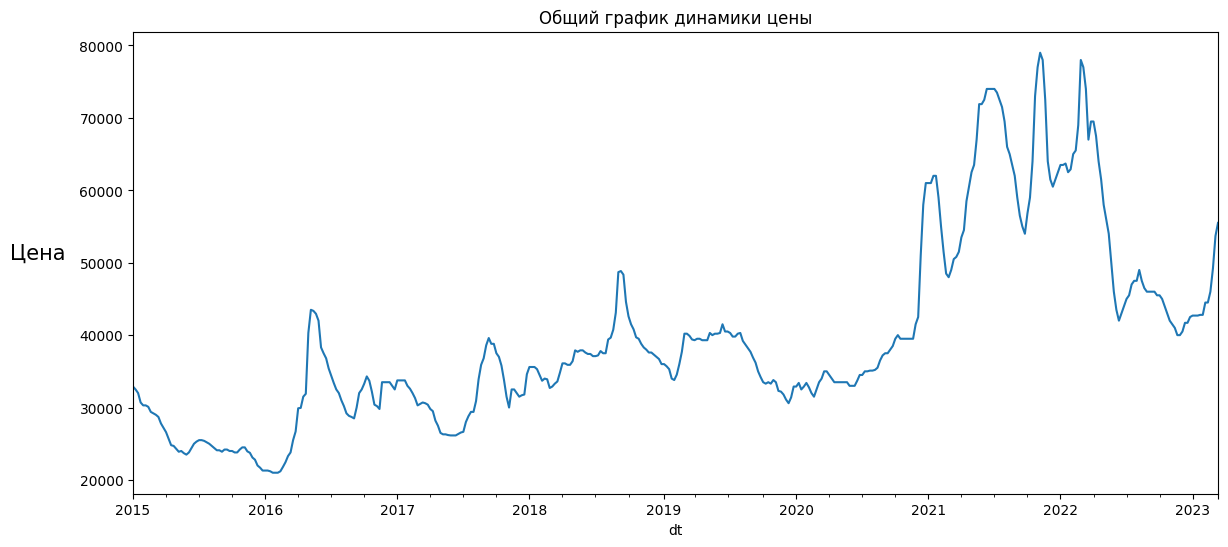

In [317]:
# Рассмотрим общий график динамики цены
plt.figure(figsize=(14, 6))
plt.title('Общий график динамики цены')
plt.ylabel('Цена', rotation=0, labelpad=30, fontsize=15)
df_extended['Цена на арматуру'].plot();

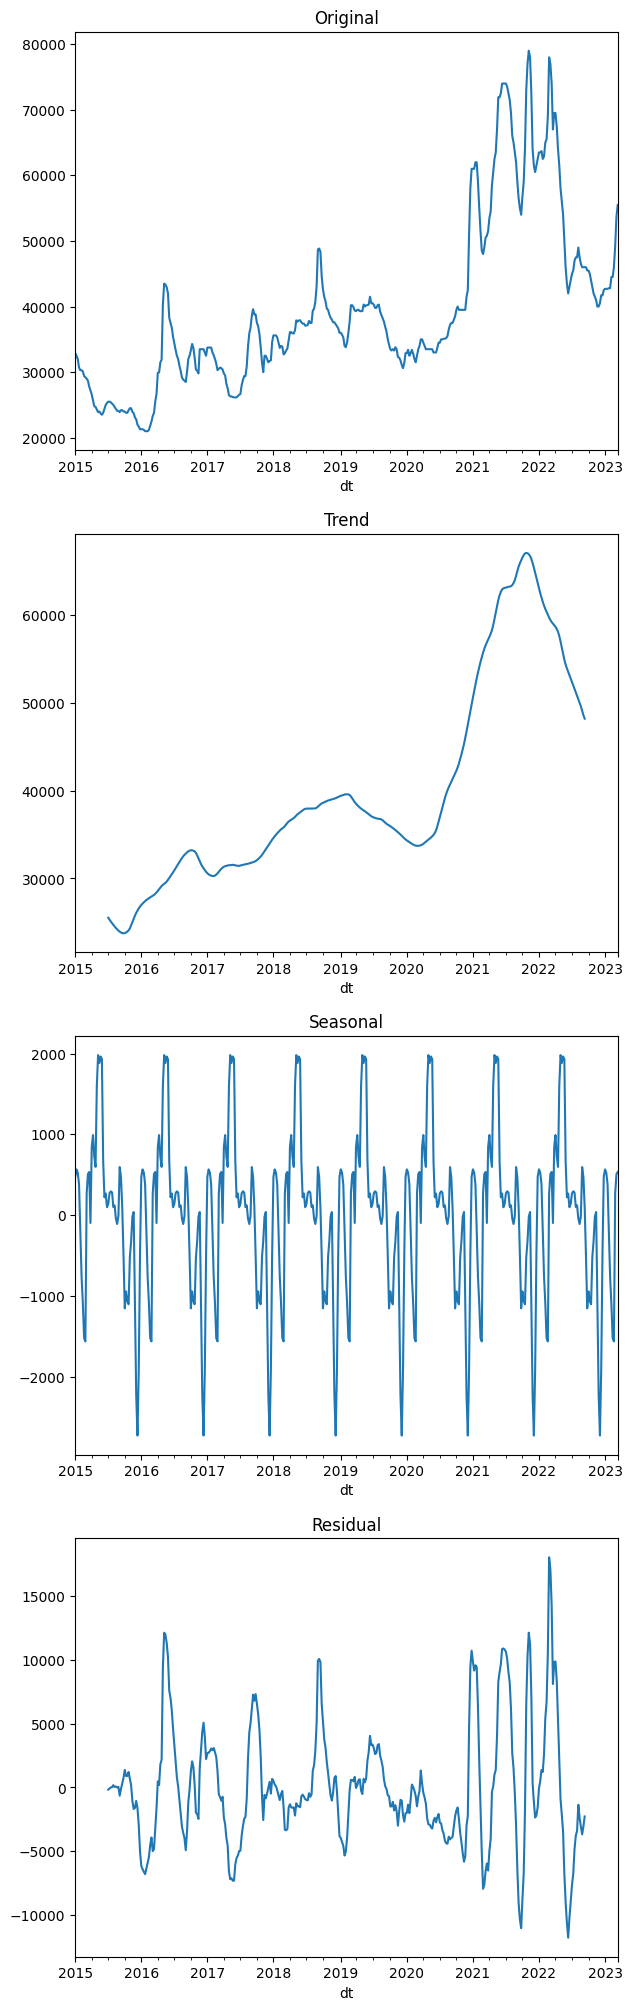

In [318]:
# Разложим ряд на компоненты и посмотрим на тренд, сезонность и шумы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(7, 25))
decompose = seasonal_decompose(df_extended[['Цена на арматуру']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

# Автокоррреляции и кареллограмма

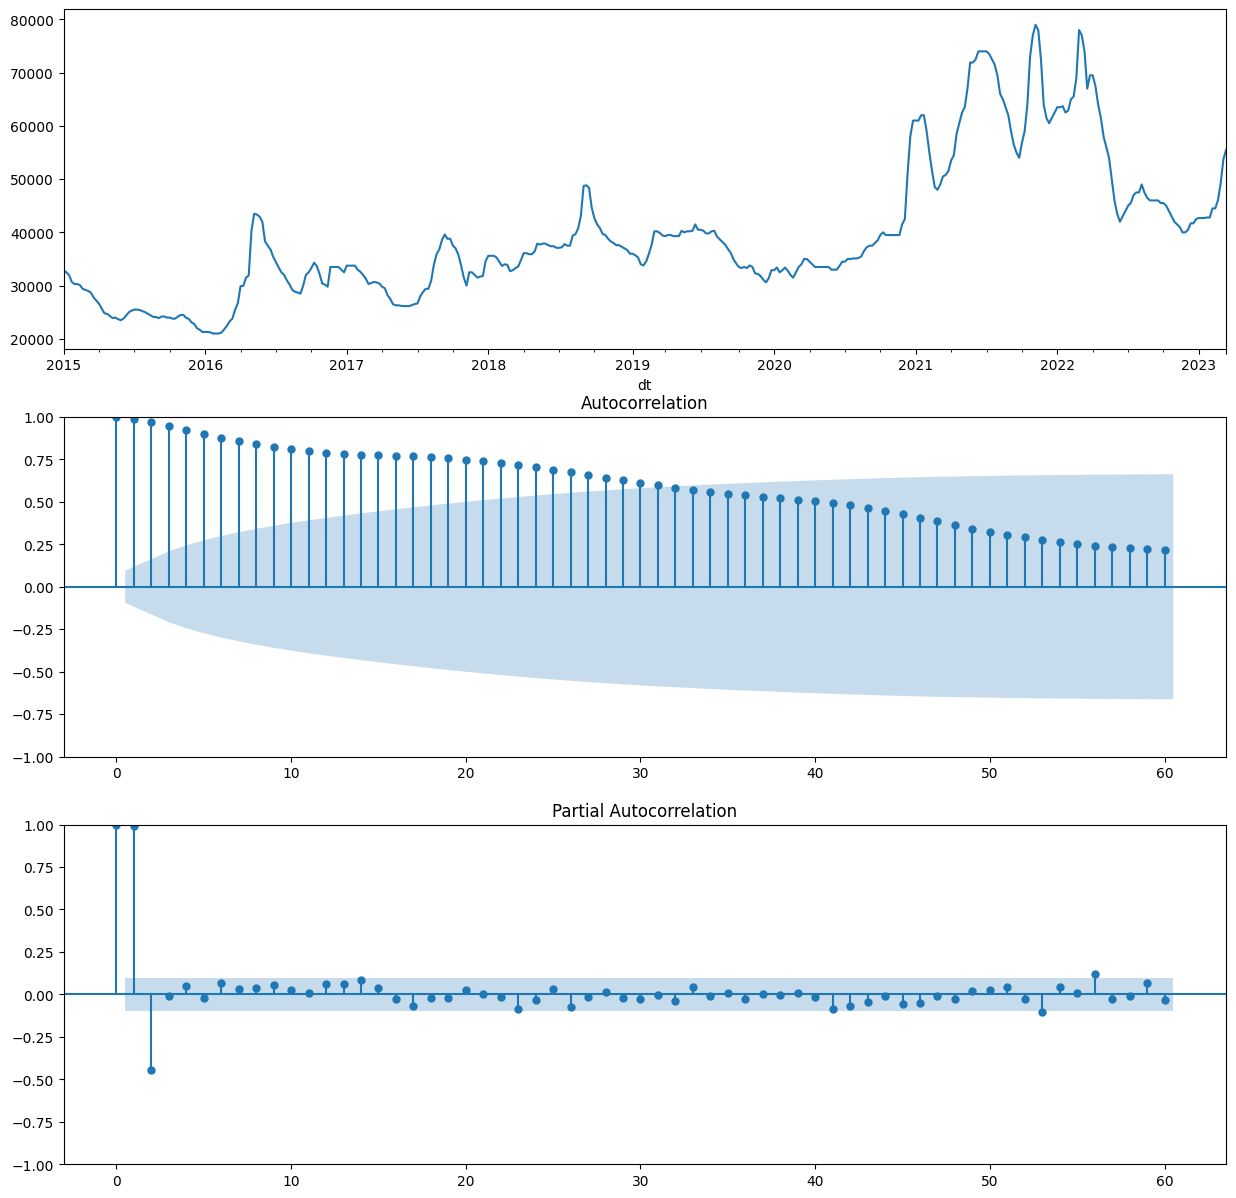

In [324]:
# построим кареллограмму
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))
df_extended['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_extended['Цена на арматуру'], lags=60, ax=ax[1])
plot_pacf(df_extended['Цена на арматуру'], lags=60, ax=ax[2]);